In [1]:
import mws

In [2]:
import numpy as np
import daisy
from funlib.geometry import Roi, Coordinate
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from skimage.transform import rescale, downscale_local_mean
from funlib.evaluate import rand_voi

In [3]:
import matplotlib.pyplot as plt
from skimage import color
from matplotlib.widgets import Slider

%matplotlib notebook

In [4]:
def evaluate(
    seg,
    labels,
    mask=None):
    
    #ensure same shape
    if mask is not None:
        if seg.shape != mask.shape:
            l_z,l_y,l_x = mask.shape[-3:]
            s_z,s_y,s_x = seg.shape[-3:]
            c_z,c_y,c_x = (min(l_z,s_z),min(l_y,s_y),min(l_x,s_x))

            seg = seg[:c_z,:c_y,:c_x] * mask[:c_z,:c_y,:c_x]

        else:
            seg = seg * mask

    if seg.shape != labels.shape:
        l_z,l_y,l_x = labels.shape[-3:]
        s_z,s_y,s_x = seg.shape[-3:]
        c_z,c_y,c_x = (min(l_z,s_z),min(l_y,s_y),min(l_x,s_x))

        labels = labels[:c_z,:c_y,:c_x]
        seg = seg[:c_z,:c_y,:c_x]

    #eval
    metrics = rand_voi(
        labels,
        seg,
        return_cluster_scores=False)

    metrics['voi_sum'] = metrics['voi_split']+metrics['voi_merge']
    metrics['nvi_sum'] = metrics['nvi_split']+metrics['nvi_merge']

    for k in {'voi_split_i', 'voi_merge_j'}:
        del metrics[k]
        
    return metrics, seg

In [5]:
def run(
    raw_file,
    raw_dataset,
    labels_dataset,
    labels_mask,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    neighborhood,
    stride,
    randomize_strides,
    algorithm,
    background_mask,
    seeds,
    clean_up):
    
    seg, proc_pred = mws.post(
        pred_file,
        pred_dataset,
        roi,
        downsampling,
        denoising,
        normalize_preds,
        neighborhood,
        stride,
        randomize_strides,
        algorithm,
        background_mask,
        seeds,
        clean_up,
        write=False)
    
    sections = list(range(len(seg))) # get sections
    init_section = int(len(seg)/2)
    
    # load unprocessed pred
    pred = daisy.open_ds(pred_file,pred_dataset)

    if roi is not None:
        roi = daisy.Roi(pred.roi.offset+daisy.Coordinate(roi[0]),roi[1])
    else:
        roi = pred.roi
            
    # prepare preds for vis
    proc_pred = np.moveaxis(proc_pred[:3,:],0,-1)
    
    # load raw, labels, labels_mask
    raw = daisy.open_ds(raw_file, raw_dataset).to_ndarray(roi, fill_value=0)#roi
    labels = daisy.open_ds(raw_file,labels_dataset).to_ndarray(roi,fill_value=0)
    
    if labels_mask:
        mask = daisy.open_ds(raw_file,labels_mask)
        mask = mask.to_ndarray(roi,fill_value=0)
    else:
        mask = None
        
    # evaluate
    results,seg = evaluate(seg,labels,mask)
    
    # setup figure
    labels = color.label2rgb(labels,colors=np.random.random((len(np.unique(labels)), 3)))
    seg = color.label2rgb(seg,colors=np.random.random((len(np.unique(seg)), 3)))
    
    fig, axes = plt.subplots(2,2,figsize=(10,6.666),sharex=False,sharey=False,squeeze=False)
    
    # vertical slider for section number
    axsection = fig.add_axes([0.035, 0.175, 0.0225, 0.63])
    section_slider = Slider(
        ax=axsection,
        label='Section',
        valmin=sections[0],
        valmax=sections[-1],
        valinit=init_section,
        valstep=sections,
        orientation="vertical")
    
    # plot
    axes[0][0].title.set_text(raw_dataset)
    raw_vis1 = axes[0][0].imshow(raw[init_section], cmap='gray')

    axes[0][1].title.set_text(f"raw + {labels_dataset}")
    raw_vis2 = axes[0][1].imshow(raw[init_section], cmap='gray')
    labels_vis = axes[0][1].imshow(labels[init_section], alpha=0.5)
    
    axes[1][0].title.set_text(f"processed {pred_dataset}")
    proc_pred_vis = axes[1][0].imshow(proc_pred[init_section])
    
    axes[1][1].title.set_text("raw + seg")
    raw_vis3 = axes[1][1].imshow(raw[init_section], cmap='gray')
    seg_vis = axes[1][1].imshow(seg[init_section], alpha=0.5)
    
    # slider update function
    def update(val):
        
        new_seg = seg[section_slider.val]
        new_raw = raw[section_slider.val]
        new_labels = labels[section_slider.val]
        new_proc_pred = proc_pred[section_slider.val]
        
        raw_vis1.set_data(new_raw)
        raw_vis2.set_data(new_raw)
        labels_vis.set_data(new_labels)
        proc_pred_vis.set_data(new_proc_pred)
        raw_vis3.set_data(new_raw)
        seg_vis.set_data(new_seg)  
        
        fig.canvas.draw_idle()

    section_slider.on_changed(update);
    
    plt.tight_layout()
    
    #print best result
    print(results)

In [6]:
def quick_run(
    raw_file,
    raw_dataset,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    neighborhood,
    stride,
    randomize_strides,
    algorithm,
    background_mask,
    seeds,
    clean_up):
    
    seg, proc_pred = mws.post(
        pred_file,
        pred_dataset,
        roi,
        downsampling,
        denoising,
        normalize_preds,
        neighborhood,
        stride,
        randomize_strides,
        algorithm,
        background_mask,
        seeds,
        clean_up,
        write=False)
    
    sections = list(range(len(seg))) # get sections
    init_section = int(len(seg)/2)
    
    # load unprocessed pred
    pred = daisy.open_ds(pred_file,pred_dataset)

    if roi is not None:
        roi = daisy.Roi(pred.roi.offset+daisy.Coordinate(roi[0]),roi[1])
    else:
        roi = pred.roi
            
    # prepare preds for vis
    pred = pred.to_ndarray(roi)
    pred = (pred/255.0).astype(np.float32) if pred.dtype==np.uint8 else pred
    
    pred = np.moveaxis(pred[:3,:],0,-1)
    proc_pred = np.moveaxis(proc_pred[:3,:],0,-1)
    
    print(pred.shape,proc_pred.shape)
    
    # load raw, 
    raw = daisy.open_ds(raw_file, raw_dataset).to_ndarray(roi, fill_value=0)#roi
    
    # setup figure
    seg = color.label2rgb(seg,colors=np.random.random((len(np.unique(seg)), 3)))
    
    fig, axes = plt.subplots(2,2,figsize=(10,6.666),sharex=False,sharey=False,squeeze=False)
    
    # vertical slider for section number
    axsection = fig.add_axes([0.035, 0.175, 0.0225, 0.63])
    section_slider = Slider(
        ax=axsection,
        label='Section',
        valmin=sections[0],
        valmax=sections[-1],
        valinit=init_section,
        valstep=sections,
        orientation="vertical")
    
    # plot
    axes[0][0].title.set_text(raw_dataset)
    raw_vis1 = axes[0][0].imshow(raw[init_section], cmap='gray')

    axes[0][1].title.set_text(f"predicted {pred_dataset}")
    pred_vis = axes[0][1].imshow(pred[init_section])
    
    axes[1][0].title.set_text(f"processed {pred_dataset}")
    proc_pred_vis = axes[1][0].imshow(proc_pred[init_section])
    
    axes[1][1].title.set_text("raw + seg")
    raw_vis2 = axes[1][1].imshow(raw[init_section], cmap='gray')
    seg_vis = axes[1][1].imshow(seg[init_section], alpha=0.5)
    
    # slider update function
    def update(val):
        
        new_seg = seg[section_slider.val]
        new_raw = raw[section_slider.val]
        new_proc_pred = proc_pred[section_slider.val]
        new_pred = pred[section_slider.val]
        
        raw_vis1.set_data(new_raw)
        raw_vis2.set_data(new_raw)
        pred_vis.set_data(new_pred)
        proc_pred_vis.set_data(new_proc_pred)
        seg_vis.set_data(new_seg)  
        
        fig.canvas.draw_idle()

    section_slider.on_changed(update);
    
    plt.tight_layout()

In [11]:
raw_file = '/scratch/04101/vvenu/xray-challenge-entry/data/xpress-challenge.zarr'
pred_file = '/scratch/04101/vvenu/xray-challenge-entry/setups/setup16/predictions.zarr'
pred_dataset = 'pred_affs'
labels_dataset = None#"labels"
raw_dataset = "volumes/training_raw"
labels_mask = None#"labels_mask"

seeds = (raw_file,"volumes/training_gt_rasters")
roi = ((581*33, 509*33, 498*33),(3300,3300,3300))

# raw_file = "/scratch/04101/vvenu/xray-challenge-entry/data/xpress-challenge.zarr"
# raw_dataset = "volumes/validation_raw"
# #pred_file = "/scratch/04101/vvenu/xray-challenge-entry/setups/vijay_baselines/NoiseAug_mtlsd/xpress-challenge.zarr"
# pred_file = "/scratch/04101/vvenu/xray-challenge-entry/setups/vijay_baselines/Lsd_to_affs/LR_arlo_lite/xpress-challenge.zarr"
# pred_dataset = "lsd/3d_affs_20000_from_lsds_2000"
# #pred_dataset = "affs_2000"

# roi = None
#roi = ((1500, 5160, 5488),(500, 1600, 1600)) #oblique
# roi = ((6600,3300,3300),(3300,3300,3300))

downsampling = None#["rescale",2]
denoising = None#['tv', 0.01, 0]
normalize_preds = False

if "voljo" in pred_file and "MR" not in pred_file:
    neighborhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1], [-2, 0, 0], [0, -2, 0], [0, 0, -2], [0, -4, 0], [0, 0, -4], [0, -8, 0], [0, 0, -8], [0, -3, -7], [0, -6, -6], [0, -7, -3], [0, -7, 3], [0, -6, 6], [0, -3, 7]]
elif "epi" in pred_file:
    neighborhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1], [-2, 0, 0], [0, -2, 0], [0, 0, -2], [0, -4, 0], [0, 0, -4], [0, -6, 0], [0, 0, -6], [0, -1, -5], [0, -4, -4], [0, -5, -1], [0, -5, 1], [0, -4, 4], [0, -1, 5]]
elif "cremi" in pred_file:
    neighborhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1], [-2, 0, 0], [0, -2, 0], [0, 0, -2], [0, -4, 0], [0, 0, -4], [0, -8, 0], [0, 0, -8], [0, -3, -7], [0, -6, -6], [0, -7, -3], [0, -7, 3], [0, -6, 6], [0, -3, 7]]
elif "fib25" in pred_file:
    neighborhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1], [-2, 0, 0], [0, -2, 0], [0, 0, -2], [-4, 0, 0], [0, -4, 0], [0, 0, -4], [-4, -4, 0], [-4, 4, 0], [0, -4, -4], [0, -4, 4], [-4, 0, -4], [-4, 0, 4]]
elif "xray" in pred_file:
    neighborhood = [
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [2, 0, 0],
        [0, 2, 0],
        [0, 0, 2],
        [4, 0, 0],
        [0, 4, 0],
        [0, 0, 4],
        [8, 0, 0],
        [0, 8, 0],
        [0, 0, 8],
        [0, 0, 8],
        [0, 3, 7],
        [0, 6, 6],
        [0, 7, 3],
        [0, 8, 0],
        [0, 7, -3],
        [0, 6, -6],
        [0, 3, -7]]
elif "MR" in pred_file:
    neighborhood = [[-1, 0, 0], [0, -1, 0], [0, 0, -1], [-2, 0, 0], [0, -4, 0], [0, 0, -4]]
else:
    raise AssertionError("idk what neighborhood.")

stride = [4,4,4]
algorithm = "seeded"
background_mask=False
randomize_strides=True
clean_up=True

(100, 100, 100, 3) (100, 100, 100, 3)


<IPython.core.display.Javascript object>


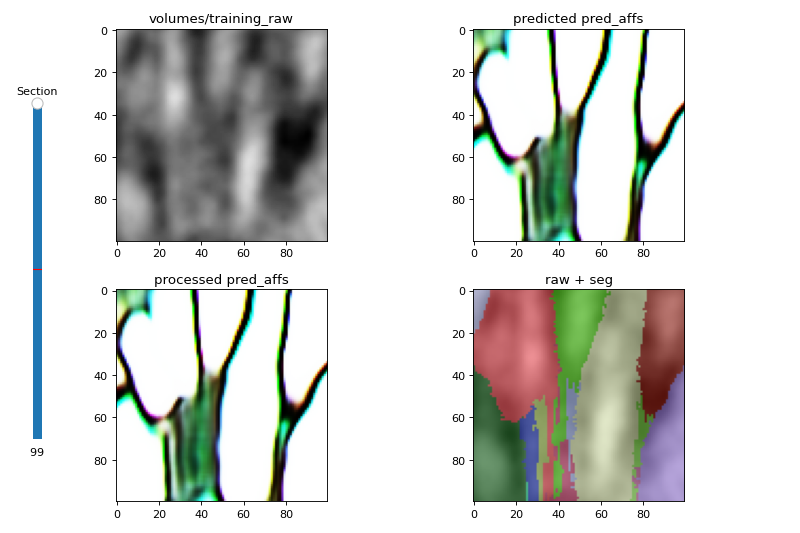

/tmp/ipykernel_2971260/3063050154.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [13]:
quick_run(
    raw_file,
    raw_dataset,
    pred_file,
    pred_dataset,
    roi,
    downsampling,
    denoising,
    normalize_preds,
    neighborhood,
    stride,
    randomize_strides,
    algorithm,
    background_mask,
    seeds,
    clean_up)